In [1]:
import qutip
import numpy as np
from scipy.linalg import expm


In [2]:
!python -m pip freeze > requirements.txt

In [3]:
def build_init_state(a, b, c):
    inita = qutip.basis(2, a)
    initb = qutip.basis(2, b)
    initc = qutip.basis(2, c)
    init = qutip.tensor(inita, initb, initc)
    return init

In [4]:
# pretty print from Chao
import matplotlib.pyplot as plt


def plotMatrix(matrix, rounder=2, vmin=0, vmax=1):
    matrix = np.array(matrix)
    dim = len(matrix)
    nBits = int(np.log2(dim))
    number_label = np.arange(0, dim, 1)
    fig = plt.figure(figsize=(7, 7))
    plt.subplot(1, 1, 1)
    pm = plt.imshow(np.abs(matrix), interpolation="nearest", vmin=vmin, vmax=vmax)
    plt.xticks(number_label, [f"{n:0{nBits}b}" for n in number_label])
    plt.yticks(number_label, [f"{n:0{nBits}b}" for n in number_label])
    for (j, i), label in np.ndenumerate(matrix):
        label = np.round(label, rounder)
        plt.text(i, j, label, ha="center", va="center")
    plt.colorbar()
    plt.show()
    return pm


First,  by inspection construct a target unitary for cyclic_3 swap.

$U|a, b, c\rangle = |b,c,a\rangle$.

\begin{equation}
\begin{bmatrix}
1& 0& 0& 0& 0& 0& 0& 0\\
0& 0& 0& 0& 1& 0& 0& 0\\
0& 1& 0& 0& 0& 0& 0& 0\\
0& 0& 0& 0& 0& 1& 0& 0\\
0& 0& 1& 0& 0& 0& 0& 0\\
0& 0& 0& 0& 0& 0& 1& 0\\
0& 0& 0& 1& 0& 0& 0& 0\\
0& 0& 0& 0& 0& 0& 0& 1
\end{bmatrix}

\begin{bmatrix}
a\\
b\\
c\\
d\\
e\\
f\\
g\\
h
\end{bmatrix}
=
\begin{bmatrix}
a\\
e\\
b\\
f\\
c\\
g\\
d\\
h
\end{bmatrix}
\end{equation}

In [5]:
# def gaussian(t, u, s):
#     return (np.exp(-.5*((t-u)/s)**2))/np.sqrt(2*np.pi)

def gaussian(t, A, s):
    return A*np.exp(-(t/s)**2)

In [6]:
def build_circulator_U(
    phi_ab=0, phi_ac=0, phi_bc=np.pi / 2, g_ab=1.0, g_ac=1.0, g_bc=1.0
):
    # TODO: when sweeping phase parameters leave time-independent
    # when sweeping coupling parameters make time-dependet i.e gaussian shaped pusle
    # build raising and lowering operations
    a = qutip.operators.create(N=2)
    I2 = qutip.operators.identity(2)
    A = qutip.tensor(a, I2, I2)
    B = qutip.tensor(I2, a, I2)
    C = qutip.tensor(I2, I2, a)

    # construct circulator Hamiltonian
    H_ab = np.exp(1j * phi_ab) * A * B.dag() + np.exp(-1j * phi_ab) * A.dag() * B
    H_ac = np.exp(1j * phi_ac) * A * C.dag() + np.exp(-1j * phi_ac) * A.dag() * C
    H_bc = np.exp(1j * phi_bc) * B * C.dag() + np.exp(-1j * phi_bc) * B.dag() * C
    H = g_ac * H_ac + g_bc * H_bc + g_ab * H_ab

    # time evolution, if time dependent need to use master-equation
    # qutip.mesolve()
    # U = expm(1j*np.array(H))
    U = (1j * H).expm()
    return U

def _wrap_build_time_dependent_U(phi_ab=0, phi_ac=0, phi_bc=np.pi / 2, g_ab_A=0, g_ab_s=.1, g_ac_A=0, g_ac_s=.1, g_bc_A=0, g_bc_s=.1):
    a = qutip.operators.create(N=2)
    I2 = qutip.operators.identity(2)
    A = qutip.tensor(a, I2, I2)
    B = qutip.tensor(I2, a, I2)
    C = qutip.tensor(I2, I2, a)

    # construct circulator Hamiltonian
    H_ab = np.exp(1j * phi_ab) * A * B.dag() + np.exp(-1j * phi_ab) * A.dag() * B
    H_ac = np.exp(1j * phi_ac) * A * C.dag() + np.exp(-1j * phi_ac) * A.dag() * C
    H_bc = np.exp(1j * phi_bc) * B * C.dag() + np.exp(-1j * phi_bc) * B.dag() * C
    build_time_dependent_U = lambda t, args: gaussian(t,g_ab_A,g_ab_s) * H_ab + gaussian(t,g_ac_A,g_ac_s) * H_ac + gaussian(t,g_bc_A,g_bc_s) * H_bc
    return build_time_dependent_U

qutip.Qobj()
t_list = np.linspace(-1,1,100)

# H = qutip.QobjEvo(build_time_dependent_U, args, tlist=t_list)
# H_ab = np.exp(1j * 0) * A * B.dag() + np.exp(-1j * 0) * A.dag() * B
init = build_init_state(0, 1, 1)
build_time_dependent_U = _wrap_build_time_dependent_U()
result = qutip.mesolve(build_time_dependent_U, init, t_list)

# #construct an example initial state
# inita = qutip.basis(2, 1)
# initb = qutip.basis(2, 0)
# initc = qutip.basis(2, 0)
# init = qutip.tensor(inita, initb, initc)
# #print(init)

# U = build_circulator_U()
# #apply unitary to initial state
# new_state = U*init
# print(new_state)


# #expected
# expected = qutip.tensor(initb, initc, inita)
# print(expected.overlap(new_state))


In [7]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)


In [8]:
def SwapGate(n):
    a= np.exp(1j * np.pi * n/2)*np.cos(np.pi*n/2)
    b = -1j * np.exp(1j * np.pi * n/2)*np.sin(np.pi*n/2)
    return np.array([[1,0,0,0], [0,a,b,0], [0,b,a,0], [0,0,0,1]])
# plotMatrix(SwapGate(.5))

In [24]:
import qutip
import numpy as np

#build single fixed in time instance of U
def build_simulU(gx, gy, gz):
    a = qutip.operators.create(N=2)
    I2 = qutip.operators.identity(2)
    A = qutip.tensor(a, I2)
    B = qutip.tensor(I2, a)
    H = gx * (A + A.dag()) + gy * (B + B.dag()) + gz * (A*B.dag() + A.dag()*B)
    return lambda t: (1j * t * H).expm()

#unitary difference
from weylchamber import canonical_gate, g1g2g3, bell_basis,J_T_LI
def unitary_difference(u1,u2):
    #return J_T_LI(u1, u2)
    #h = np.matrix(u1).getH()
    #h = np.matrix(canonical_gate(*c1c2c3(u1))).getH()
    h = np.matrix(bell_basis(u1)).getH()
    return 1- np.abs(np.trace(np.matmul(h, bell_basis(u2))))/ np.array(u1).shape[0]
    #g = g1g2g3(u1)
    #return np.linalg.norm(np.array(g)- np.array(g1g2g3(u2)))

# #callback
from weylchamber import c1c2c3
coordinate_list = []
loss_list = []
def saveCoords(Xk):
    #reconstruct current state
    #Ucur = build_time_dependent_U(N, Xk)
    #Ucur = build_simulU(gxy[0], gxy[1], gz=1)(timestep).full()
    #coordinate_list.append(c1c2c3(Ucur))
    loss_list.append(opt_fun(Xk))
    logging.info(f"{loss_list[-1]}")

#building time dependent U
def build_time_dependent_U(N, gxy, startingU=None):
    if COORD_DEBUG: coordinate_list = []

    if startingU is None:
        totalUi = np.eye(4)
    else:
        totalUi = startingU

    for it in range(N): #enumerate(np.linspace(0,final_time, N)):

        final_time = gxy[-1] #np.pi/2 #set to np.pi/2 for exactly full iswap
        timestep = final_time/N

        ## Ui = build_simulU(gxy[it], gxy[N+it], gz=1)(ti).full()
        ## coordinate_list.append(c1c2c3(Ui))
        Ui = build_simulU(gxy[it], gxy[N+it], gz=1)(timestep).full()
        totalUi = Ui @ totalUi
        if COORD_DEBUG: coordinate_list.append(c1c2c3(totalUi))
    if COORD_DEBUG:
        return totalUi, coordinate_list
    else:
        return totalUi

#optimizer
import scipy.optimize as opt
from qiskit.quantum_info import Operator

#Strategy 1.
#try and fit final point to target

N = 10
COORD_DEBUG = False
swap_fraction = 1
swap_gate_target = SwapGate(swap_fraction)
opt_fun = lambda gxy : unitary_difference(build_time_dependent_U(N, gxy), swap_gate_target)

#restart_attempts=10
best_result = None
while (best_result is None or best_result.fun > 1e-9):
    gxy = np.ndarray.flatten(np.random.randn(2,N)) #np.ndarray.flatten(np.zeros((2,N)))
    gxy = np.concatenate((gxy, abs(np.random.randn(1))))
    # bounds = [(0, None) for _ in range(2*N+1)]
    bounds = [(0, None) for _ in range(2*N)]
    bounds += [(0, np.pi/2)] #add bound for time to be at most a full iSwap

    result = opt.minimize(fun=opt_fun, x0=gxy, callback=saveCoords, bounds=bounds)
    if best_result is None or result.fun < best_result.fun:
        best_gxy = gxy
        best_result = result
result = best_result

#Strategy 2.
#try and fit every point along the way to line leading to target
#NOTE: I think this strategy fails to recognize that path solution is not along 0-A3 line
# i.e., what if we instead need to drive along a curve to reach the final swap target?
# if that is the case, then only fitting the final unitary should be better
# however, I am not finding solutions with that yet so I will try this alternative approach for comparison
"""
outer_N = 50
swap_fraction = 1/5
COORD_DEBUG = False
startingU = None
gxy_total = np.zeros((2,outer_N))
for ni in range(outer_N):
    #for each ni, starting U should be best result from previous iteration
    N = 1
    gxy= np.ndarray.flatten(np.random.randn(2,N))
    swap_gate_target = SwapGate(swap_fraction/(outer_N-ni))
    opt_fun = lambda gxy : unitary_difference(build_time_dependent_U(N, gxy, startingU=startingU), swap_gate_target)
    result = opt.minimize(fun=opt_fun, x0=gxy, callback=saveCoords)
    startingU = build_time_dependent_U(N, result.x)
    gxy_total[0, ni] = result.x[0]
    gxy_total[1, ni] = result.x[1]
gxy_total = np.ndarray.flatten(gxy_total)
"""

#Strategy 3.
#NOTE: currently, target is only a single instance of a SWAP family gate
# we might instead let this be any SWAP family gate by minimizing distance to O-A3 line from current point
# my concern is that the found solution will always be the Identity gate, we need to define some threshold
# say it can find any gate along the line as long as it is above for example Swap^1/5
# otherwise too much error acculumates when combining to make a swap
# define new error function which is just distance to SWAP family line
#
# def unitary_difference(u1,u2):
#     pass
    #how do you defined shortest distance between point and a line segment?

#Strategy 4.
#Sweep k, are there any solutions to Swap^(K/50) in a single time step?
#adapt strategy 2, but don't use previous guess as a starting point
"""
outer_N = 10
swap_fraction = 1
COORD_DEBUG = False
gxy_total = np.zeros((3,outer_N)) #im adding in a 3rd row to be ideal timestep so I can sweep that too
for ni in range(outer_N):
    N = 1
    gxy= np.ndarray.flatten(np.random.randn(3,N))
    swap_gate_target = SwapGate(swap_fraction/(outer_N-ni))
    opt_fun = lambda gxy : unitary_difference(build_time_dependent_U(N, gxy), swap_gate_target)
    result = opt.minimize(fun=opt_fun, x0=gxy, callback=saveCoords)
    gxy_total[0, ni] = result.x[0]
    gxy_total[1, ni] = result.x[1]
    gxy_total[2, ni] = result.x[2] #optimal timestep
gxy_total = np.ndarray.flatten(gxy_total)
"""

INFO:root:0.4993523952093526
INFO:root:0.4897720760166149
INFO:root:0.4041962502086168
INFO:root:0.29289321881345276
INFO:root:0.49608997356172646
INFO:root:0.47539944310372695
INFO:root:0.46388781441822236
INFO:root:0.34237840821914745
INFO:root:0.29289321881345276
INFO:root:0.41966398977138364
INFO:root:0.39721384525308434
INFO:root:0.35577880187080646
INFO:root:0.310886255079887
INFO:root:0.2984032065761879
INFO:root:0.29289321881345276
INFO:root:0.4841692072236464
INFO:root:0.41990986701893773
INFO:root:0.39822016828755225
INFO:root:0.35281563324752285
INFO:root:0.29289321881345276
INFO:root:0.4945620069586921
INFO:root:0.4390235886427776
INFO:root:0.40593590865995677
INFO:root:0.37495463571594667
INFO:root:0.29764217932243153
INFO:root:0.29289321881345276
INFO:root:0.4710775591379037
INFO:root:0.40801901796941453
INFO:root:0.3438476823647719
INFO:root:0.3085090178657941
INFO:root:0.29289321881345276
INFO:root:0.49979085419222935
INFO:root:0.436988696251729
INFO:root:0.436781980655

KeyboardInterrupt: 

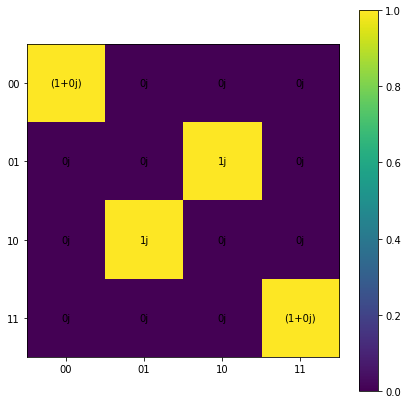

In [22]:
plotMatrix(build_simulU(0,0,1)(np.pi/2).full())

In [14]:
swap_gate_target = SwapGate(1)
COORD_DEBUG=False
unitary_difference(build_time_dependent_U(N, result.x), swap_gate_target)

3.6970948524839287e-10

In [11]:
# %matplotlib widget

In [16]:
result.x

array([0.4329899 , 0.43300955, 0.        , 0.4330286 , 0.43297696,
       1.93655655, 4.71235515])

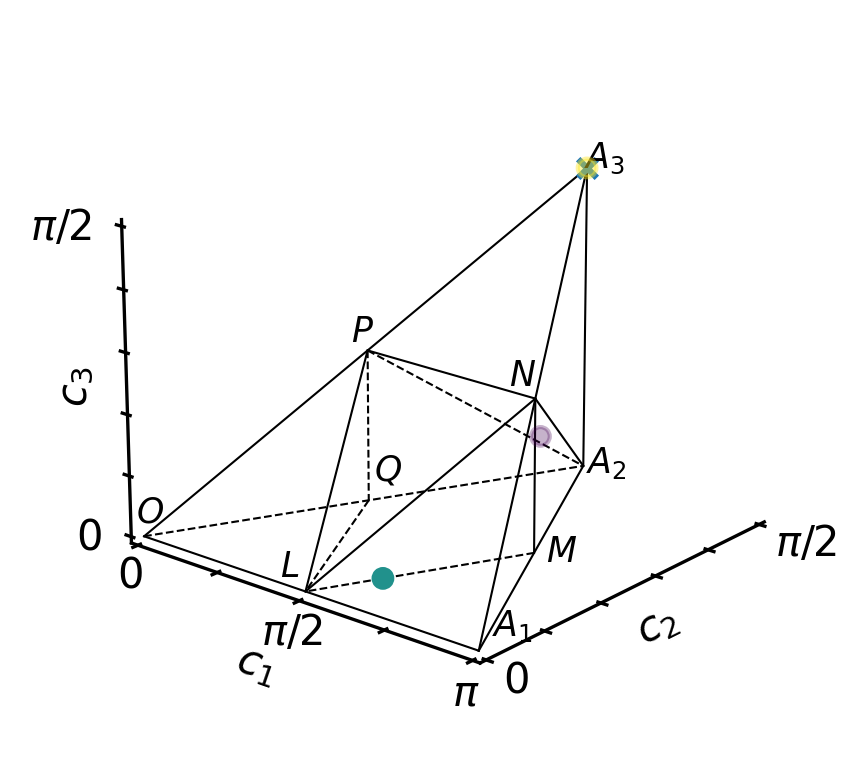

In [26]:
#plotting strategy 1
COORD_DEBUG=True
from weylchamber import WeylChamber
w = WeylChamber();
_, coordinate_list = build_time_dependent_U(N, result.x)
col = np.arange(len(coordinate_list))
w.scatter(*zip(*coordinate_list), c=col, marker='o')
w.scatter(*c1c2c3(swap_gate_target), marker='x')
w.plot()

In [27]:
print(result.x)

[0.43300768 0.         0.43302225 0.43302316 1.93648492 0.43303932
 4.71235552]


In [ ]:
# #plotting startegy 4
# %matplotlib widget
# COORD_DEBUG=True
# # _, coordinate_list = build_time_dependent_U(N, result.x)
# coordinate_list = []
# for ni in range(outer_N):
#     _, temp_coordinate_list = build_time_dependent_U(1, [gxy_total[ni], gxy_total[N+ni], gxy_total[2*N+ni]])
#     coordinate_list += temp_coordinate_list
# from weylchamber import WeylChamber
# w = WeylChamber()
# col = np.arange(len(coordinate_list))
# w = WeylChamber();
# w.scatter(*zip(*coordinate_list), c=col, marker='o')

# target_coords = []
# for ni in range(outer_N):
#     swap_gate_target = SwapGate(swap_fraction/(outer_N-ni))
#     target_coords.append(c1c2c3(swap_gate_target))
# w.scatter(*zip(*target_coords), c=col, marker='x')
# #w.scatter(*c1c2c3(swap_gate_target), marker='x')
# w.plot()

NameError: name 'outer_N' is not defined

In [12]:
import numpy as np
N=10

gxy

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ,
       0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

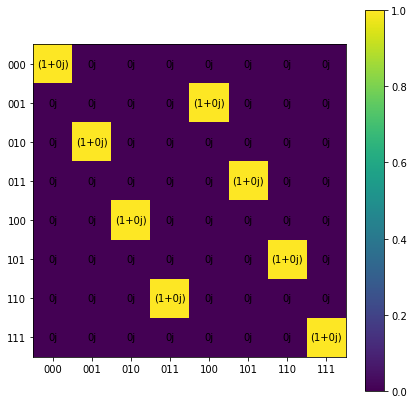

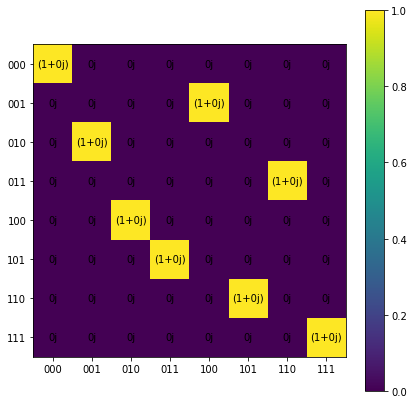

In [94]:
expected_U = qutip.Qobj(
    dims=[[2, 2, 2], [2, 2, 2]],
    inpt=(1.0 + 0j)
    * np.array(
        [
            [1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 1],
        ]
    ),
)
# gk = [1,1,1]
# template = build_circulator_U(g_ab=gk[0], g_ac=gk[1], g_bc=gk[2])
# #1- np.abs(np.sum(np.matmul(template.full(), expected.conj().full())))/ (2*np.log2(expected.shape[0]))
# np.real(((expected_U.full() - template.full()) * (expected_U.full() - template.full()).conj()).mean() ** 0.5)
# print(expected_U)
# np.abs((expected_U*template.dag()).tr())/expected_U.shape[0]

guess_U = qutip.Qobj(
    dims=[[2, 2, 2], [2, 2, 2]],
    inpt=(1.0 + 0j)
    * np.array(
        [
            [1, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 1, 0, 0, 0],
            [0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 1, 0],
            [0, 0, 1, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 1],
        ]
    ),
)
plotMatrix(expected_U)
plotMatrix(guess_U)
expected_U = guess_U


#well of course this breask for 3qubit gate
# import weylchamber
# weylchamber.concurrence(*weylchamber.c1c2c3(expected_U))


In [90]:
from scipy import optimize as opt
from itertools import product

# initial guess, here I'm letting phases also be parametric
gk = [np.random.random() for _ in range(6)]
nn= 3*np.sqrt(3)/2
gk = [np.pi/2, np.pi/2, np.pi / 2, np.pi/nn, np.pi/nn, np.pi/nn]
#gk = [0,0,np.pi/2, 1,.1,1,.1,1,.1]

In [95]:
# Option 1. Optimize inner product of quantum states
# Problem is that we want the expected inner product to be the same over all states not just 1 at a time
# construct an example initial state
# expected
# expected_state = qutip.tensor(initb, initc, inita)
init = build_init_state(0, 1, 1)
expected_state = expected_U * init
# print(expected_state)


# can we improve this by iterating over all coherent states?
def min_coherent_innerproduct(gk):
    sum = 0
    k = 0
    for a, b, c in product([0, 1], repeat=3):
        init = build_init_state(a, b, c)
        # inner_product = expected_state.overlap(
        #     build_circulator_U(
        #         phi_ab=gk[0],
        #         phi_ac=gk[1],
        #         phi_bc=gk[2],
        #         g_ab=gk[3],
        #         g_ac=gk[4],
        #         g_bc=gk[5],
        #     )
        #     * init
        # )
        build_time_dependent_U = _wrap_build_time_dependent_U(*gk)
        result = qutip.mesolve(build_time_dependent_U, init, t_list)
        inner_product = expected_state.overlap(result.states[-1])
        sum += 1 - np.real(np.conj(inner_product) * inner_product)
        k += 1
    return sum / k


# Option 2. Optmize target unitary difference
# Here I use the normalized overlap of the anstantz and target, the absolute value is taken to ignore global phase.
def min_unitary_distance(gk):
    template = build_circulator_U(
        phi_ab=gk[0], phi_ac=gk[1], phi_bc=gk[2], g_ab=gk[3], g_ac=gk[4], g_bc=gk[5]
    )
    return 1- np.abs(np.trace(np.matmul(np.matrix(expected_U).getH(), np.matrix(template))))/ np.array(expected_U).shape[0]
    #return 1- (np.abs(np.trace(np.matmul(np.matrix(expected_U).getH(), np.matrix(template))))**2 + np.array(expected_U).shape[0]) / (np.array(expected_U).shape[0]*(np.array(expected_U).shape[0]+1))


#opt_result = opt.minimize(fun=min_coherent_innerproduct, x0=gk)
opt_result = opt.minimize(fun=min_unitary_distance, x0=gk)
print(opt_result.fun)
print(opt_result.x)

# gk = opt_result.x
# U = build_circulator_U(g_ab=gk[0], g_ac=gk[1], g_bc=gk[2])
# from pprint import pprint
# pprint(np.matrix(U))


0.3385621722338752
[2.61799406 3.66519179 2.61799406 1.20919958 1.20919958 1.20919958]


In [84]:
# print(expected_U)

In [85]:
# print(U.full())

In [86]:
# qutip.Qobj(U)*build_init_state(1,0,0).full()

In [87]:
# from qiskit import QuantumCircuit
# from qiskit.circuit.library.standard_gates import *
# qc = QuantumCircuit(3)
# qc.append(CSwapGate(), [2,0,1])
# qc.append(CSwapGate(), [1,0,2])
# qc.swap(0,1)
# qc.swap(0,2)
# U = Operator(qc).data
# plotMatrix(U)
# qc.draw(output='mpl')

(0.25000000000000067, array([2.30847613, 2.69412473, 1.95644497, 5.14248494, 1.38178463,
       3.33525669]))


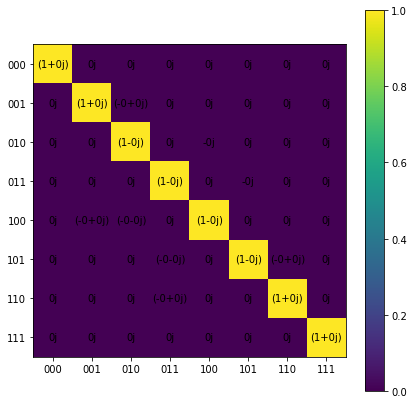

0.25000000000076483


In [116]:
#U = build_circulator_U(np.pi / 2, 0, 0, np.pi / 2, 0, 0) * build_circulator_U(0, np.pi / 2, 0, 0, np.pi / 2, 0)
from qiskit.circuit.library.standard_gates import *
from custom_gates import *
from qiskit.quantum_info import Operator
#expected_U = Operator(Margolus()).data, gives an interesting result
expected_U = Operator(CCiXGate()).data
best = (1,0)
for _ in range(20):
    gk = [np.random.random()*2*np.pi for _ in range(6)]
    opt_result = opt.minimize(fun=min_unitary_distance, x0=gk)
    if opt_result.fun < best[0]:
        best = (opt_result.fun, opt_result.x)
    if best[0] < 1e-9:
        break
print(best)

U = build_circulator_U(*opt_result.x)
plotMatrix(U)
a = min_unitary_distance(opt_result.x)
print(a)

0.0


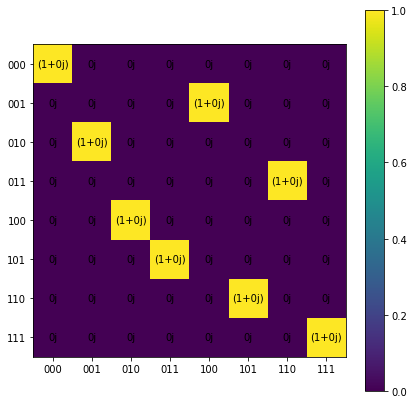

[[1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


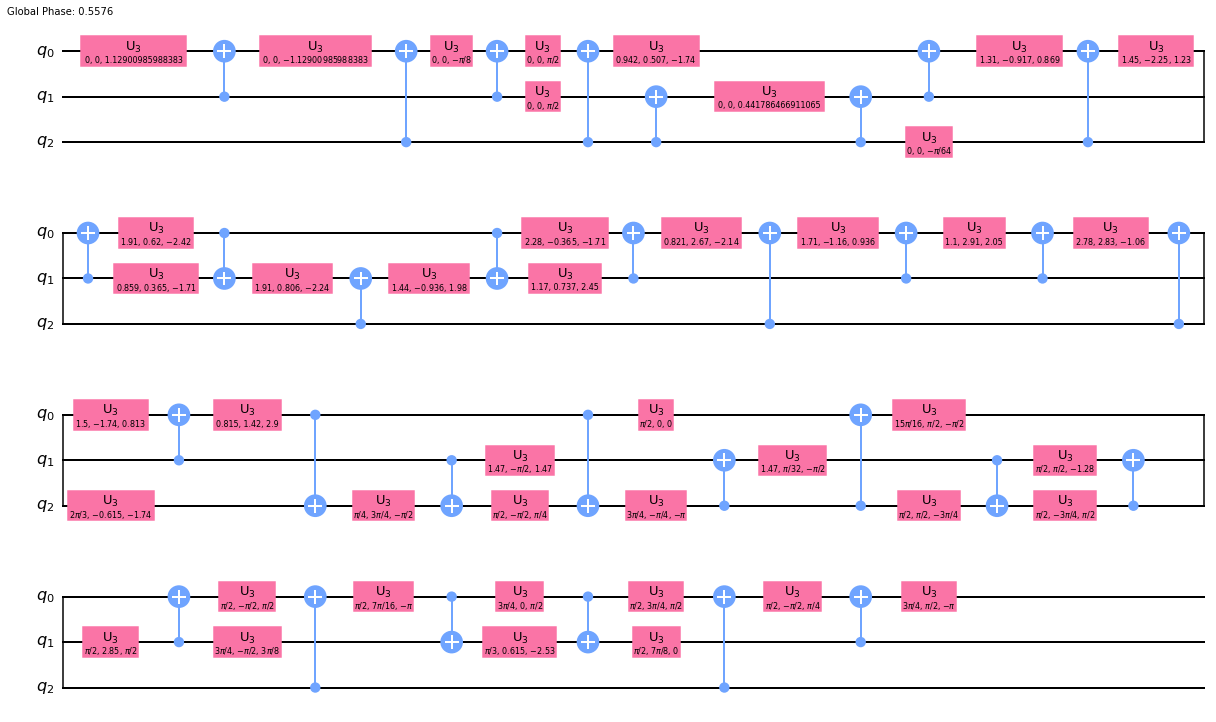

In [99]:


nn= 3*np.sqrt(3)/2
params = [-np.pi/2, np.pi/2, -np.pi / 2, np.pi/nn, np.pi/nn, np.pi/nn]

# v_nn = np.sqrt(2)*np.pi/np.arccos(1/np.sqrt(3))
# params = [0,0,0, np.pi/v_nn, np.pi/v_nn, 0]
U = build_circulator_U(*params)
# from custom_gates import VSwap
# U = VSwap().to_matrix()
a = min_unitary_distance(params)
print(a)
plotMatrix(U)

from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator
circuit = QuantumCircuit(3)
cx = Operator(U.full())
print(U.full())
circuit.unitary(cx, [0, 1,2], label='U')

from qiskit import transpile
new_circuit = transpile(circuit, basis_gates=['cx','u3','swap'], optimization_level=3)
new_circuit.draw(output='mpl')

This feels like evidence that for time-independent parameters, you just can't build the target unitary. You can get near-exact for states at a time, but if we iterate over just the most basic basis states we can't get a unitary that works for them all simultaneously. We should look into pulse control optimization methods supplied by Qutip, either GRAPE or CRAB which seem to be similar just with different optimization techniques.

https://docs.qdyn-library.net/MR-103/examples/CRAB/CRAB.html#Optimization

In [214]:
# def test_6_crab(self):
#     """
#     control.pulseoptim: Hadamard gate using CRAB algorithm
#     Apply guess and ramping pulse
#     assert that goal is achieved and fidelity error is below threshold
#     assert that starting amplitude is zero
#     """
#     # Hadamard
#     H_d = sigmaz()
#     H_c = [sigmax()]
#     U_0 = identity(2)
#     U_targ = hadamard_transform(1)

#     n_ts = 12
#     evo_time = 10

#     # Run the optimisation
#     result = cpo.opt_pulse_crab_unitary(H_d, H_c, U_0, U_targ,
#             n_ts, evo_time,
#             fid_err_targ=1e-5,
#             alg_params={'crab_pulse_params':{'randomize_coeffs':False,
#                                                 'randomize_freqs':False}},
#             init_coeff_scaling=0.5,
#             guess_pulse_type='GAUSSIAN',
#             guess_pulse_params={'variance':0.1*evo_time},
#             guess_pulse_scaling=1.0, guess_pulse_offset=1.0,
#             amp_lbound=None, amp_ubound=None,
#             ramping_pulse_type='GAUSSIAN_EDGE',
#             ramping_pulse_params={'decay_time':evo_time/100.0},
#             gen_stats=True)
#     assert_(result.goal_achieved, msg="Hadamard goal not achieved. "
#                 "Terminated due to: {}, with infidelity: {}".format(
#                 result.termination_reason, result.fid_err))
#     assert_almost_equal(result.fid_err, 0.0, decimal=3,
#                         err_msg="Hadamard infidelity too high")
#     assert_almost_equal(result.final_amps[0, 0], 0.0, decimal=3,
#                         err_msg="lead in amplitude not zero")
#     # Repeat with Qobj integration
#     result = cpo.opt_pulse_crab_unitary(H_d, H_c, U_0, U_targ,
#             n_ts, evo_time,
#             fid_err_targ=1e-5,
#             alg_params={'crab_pulse_params':{'randomize_coeffs':False,
#                                                 'randomize_freqs':False}},
#             dyn_params={'oper_dtype':Qobj},
#             init_coeff_scaling=0.5,
#             guess_pulse_type='GAUSSIAN',
#             guess_pulse_params={'variance':0.1*evo_time},
#             guess_pulse_scaling=1.0, guess_pulse_offset=1.0,
#             amp_lbound=None, amp_ubound=None,
#             ramping_pulse_type='GAUSSIAN_EDGE',
#             ramping_pulse_params={'decay_time':evo_time/100.0},
#             gen_stats=True)
#     assert_(result.goal_achieved, msg="Hadamard goal not achieved"
#                                     "(Qobj integration). "
#                 "Terminated due to: {}, with infidelity: {}".format(
#                 result.termination_reason, result.fid_err))
